## 1. Dataset

Source: ```https://www.kaggle.com/datasets/apoorvwatsky/supply-chain-shipment-pricing-data```,

```https://www.usaid.gov/data/dataset/0162a542-4f2e-4fe2-ad5d-8f6ed2344056```

This data set provides supply chain health commodity shipment and pricing data. 

Specifically, the data set identifies Antiretroviral (ARV) and HIV lab shipments to supported countries. In addition, 

the data set provides the commodity pricing and associated supply chain expenses necessary to move the commodities to countries for use.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from importlib import reload

sys.path.append('/Users/cheungjustin/PycharmProjects/QuantEquity')
import pom.util as ut
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import mutual_info_classif
from collections import defaultdict

from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

In [617]:
df = pd.read_csv('SCMS_Delivery_History_Dataset_20150929.csv', encoding='ISO-8859-1')
df = df.set_index('ID')
df

,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
ID,,,,,,,,,,,,,,,,,,,,,
1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,...,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/2014,...,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/2014,...,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/2014,...,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04


In [835]:
import re

def get_inside(s, l, r):
    if s is None or len(s) == 0:
        return None
    m = re.findall(rf'{l}(.*?){r}', s)
    assert len(m) == 1, s
    return int(m[0])
    
def split_str_cols(s, pat, s_name=None):
    if s_name is None:
        s_name = s.name
    return s.str.split(pat, expand=True).add_prefix(s_name + '_').replace('', np.nan)


df_new = df.copy()

# 0. Manual Replacement
df_new['PQ #'] = df_new['PQ #'].replace({'Pre-PQ Process': 'PrePQ-'})

# 1. Split String Columns
for col in ['Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #']:
    df_new = pd.concat([df_new.drop(columns=col), split_str_cols(df_new[col], '-')], axis=1)

# 2. Convert to datetime
date_cols = ['Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']

for col in date_cols:
    df_new[col] = pd.to_datetime(df_new[col], format='%d-%b-%y')


date_cols2 = ['PQ First Sent to Client Date', 'PO Sent to Vendor Date']
for col in date_cols2:
    s = df_new[col]
    s_new = pd.to_datetime(s, format='%m/%d/%Y', errors='coerce')
    df_new[col] = s_new
    
    if (s.notna() & s_new.isna()).sum() > 0:
        print(f'Adding str {col}')
        df_new[col+'_str'] = s[s_new.isna()]


# 3. Convert Num dtypes
num_cols = ['PQ #_1', 'PO / SO #_1', 'ASN/DN #_1', 
            'Weight (Kilograms)', 'Freight Cost (USD)']

for col in num_cols:
    s = df_new[col]
    s_new = pd.to_numeric(s, errors='coerce')
    df_new[col] = s_new

    if (s.notna() & s_new.isna()).sum() > 0:
        print(f'Adding str {col}')
        df_new[col+'_str'] = s[s_new.isna()]


# 4. Manual Impute
for corr_col in ['Weight (Kilograms)', 'Freight Cost (USD)']:
    corr_col_id = df_new[corr_col + '_str'].replace({np.nan: None, 
                                                     'Weight Captured Separately': None,
                                                    'Freight Included in Commodity Cost': None,
                                                    'Invoiced Separately': None})
    
    corr_col_id = corr_col_id.apply(lambda s: get_inside(s, l='ID#:', r=r'\)'))
    corr_val = corr_col_id.apply(lambda s: df_new.loc[s, corr_col] if not np.isnan(s) else np.nan)
    df_new[corr_col] = df_new[corr_col].fillna(corr_val)
    df_new[corr_col + '_str'] = df_new[corr_col + '_str'][corr_col_id.isna()]

df_new

Adding str PQ First Sent to Client Date
Adding str PO Sent to Vendor Date
Adding str Weight (Kilograms)
Adding str Freight Cost (USD)


,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,...,PQ #_0,PQ #_1,PO / SO #_0,PO / SO #_1,ASN/DN #_0,ASN/DN #_1,PQ First Sent to Client Date_str,PO Sent to Vendor Date_str,Weight (Kilograms)_str,Freight Cost (USD)_str
ID,,,,,,,,,,,,,,,,,,,,,
1,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,NaT,NaT,2006-06-02,2006-06-02,2006-06-02,...,PrePQ,NaN,SCMS,4,ASN,8,Pre-PQ Process,Date Not Captured,NaN,NaN
3,Vietnam,PMO - US,Direct Drop,EXW,Air,NaT,NaT,2006-11-14,2006-11-14,2006-11-14,...,PrePQ,NaN,SCMS,13,ASN,85,Pre-PQ Process,Date Not Captured,NaN,NaN
4,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,NaT,NaT,2006-08-27,2006-08-27,2006-08-27,...,PrePQ,NaN,SCMS,20,ASN,14,Pre-PQ Process,Date Not Captured,NaN,NaN
15,Vietnam,PMO - US,Direct Drop,EXW,Air,NaT,NaT,2006-09-01,2006-09-01,2006-09-01,...,PrePQ,NaN,SCMS,78,ASN,50,Pre-PQ Process,Date Not Captured,NaN,NaN
16,Vietnam,PMO - US,Direct Drop,EXW,Air,NaT,NaT,2006-08-11,2006-08-11,2006-08-11,...,PrePQ,NaN,SCMS,81,ASN,55,Pre-PQ Process,Date Not Captured,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86818,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,2014-10-16,NaT,2015-07-31,2015-07-15,2015-07-20,...,FPQ,15197.0,SO,50020,DN,4307,NaN,N/A - From RDC,NaN,NaN
86819,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,2014-10-24,NaT,2015-07-31,2015-08-06,2015-08-07,...,FPQ,15259.0,SO,50102,DN,4313,NaN,N/A - From RDC,NaN,NaN
86821,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,2014-08-12,NaT,2015-08-31,2015-08-25,2015-09-03,...,FPQ,14784.0,SO,49600,DN,4316,NaN,N/A - From RDC,Weight Captured Separately,Freight Included in Commodity Cost


## 2. EDA Wrapper

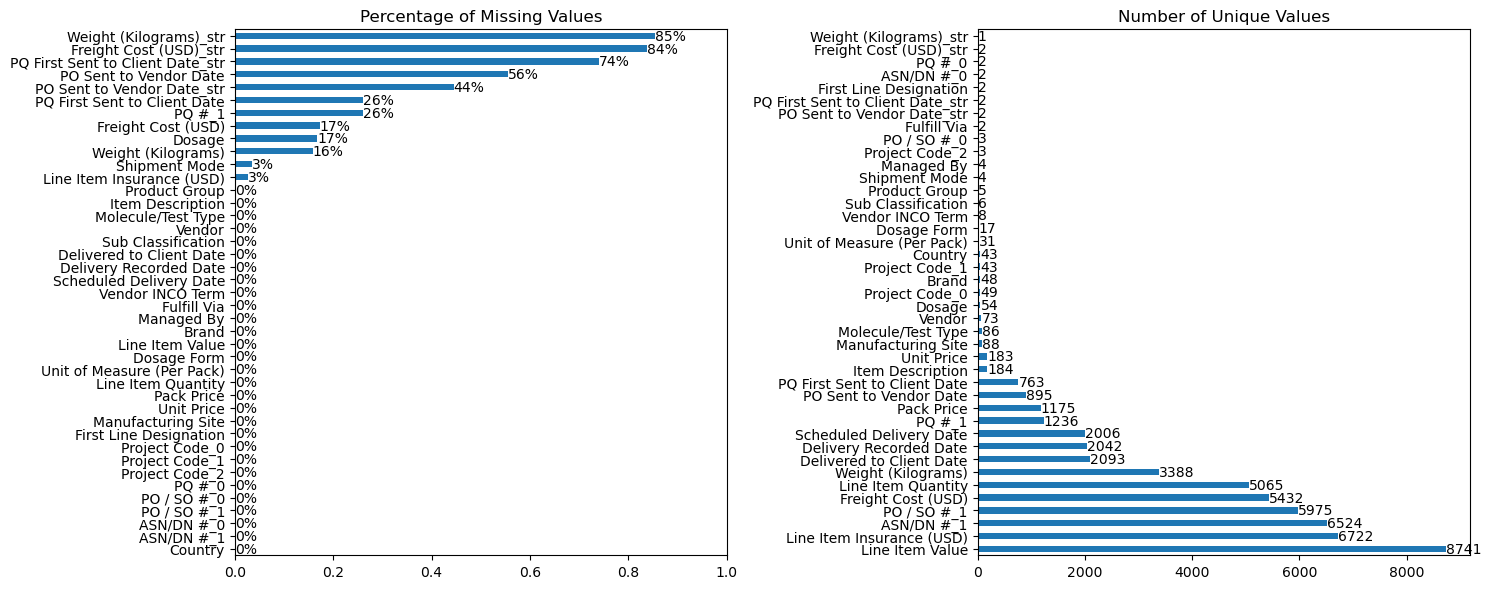

In [1393]:
reload(ut)

target = 'Unit Price'
cont_thres = 'log2'
random_state = 4012
verbose = False

dta = ut.DataAnalyzer(df_new, target=target, verbose=verbose,
                      cont_thres=cont_thres, random_state=random_state)

dta.data_quality_check();

In [1413]:
# dta.plot_categ_stats();

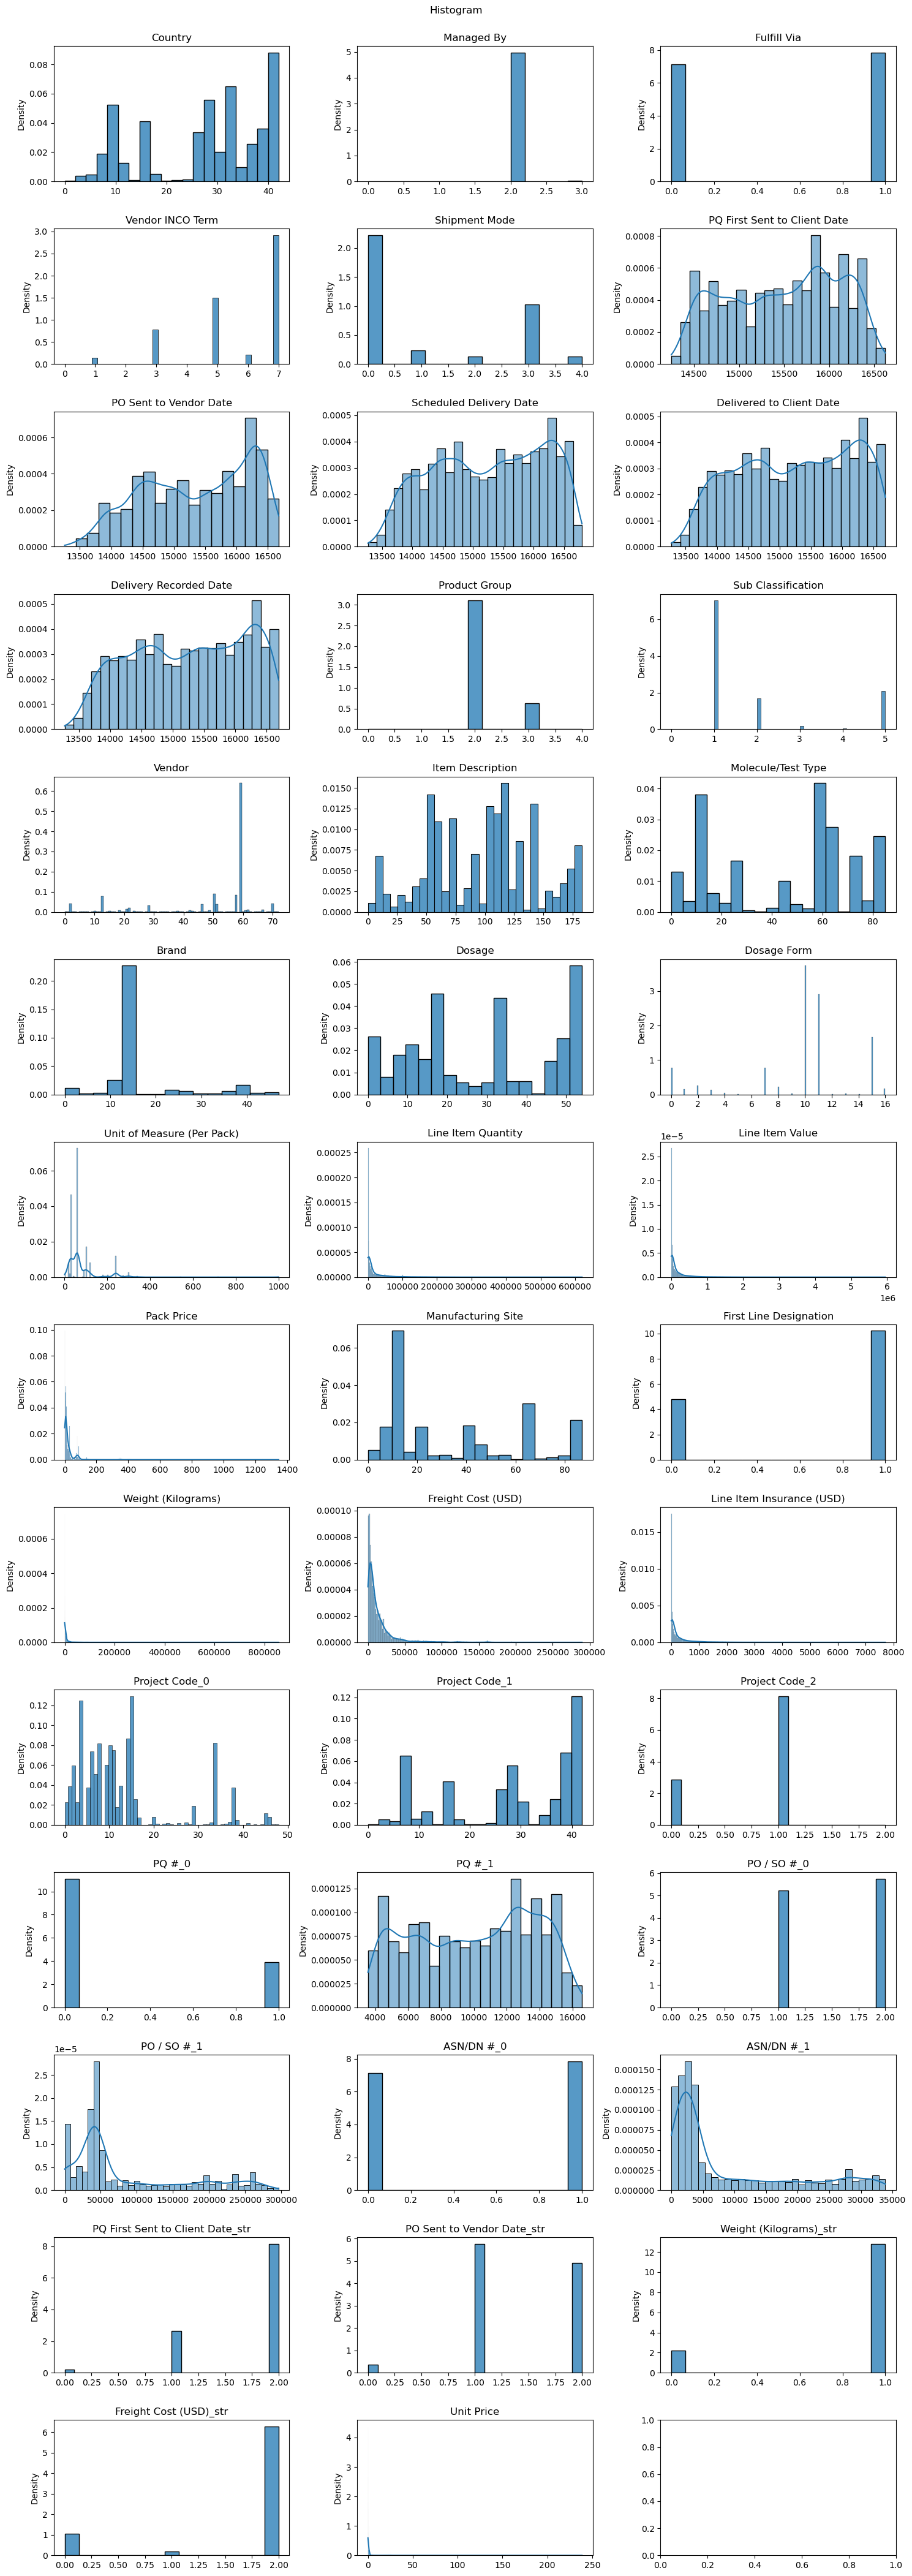

In [1396]:
dta.dist_plot();

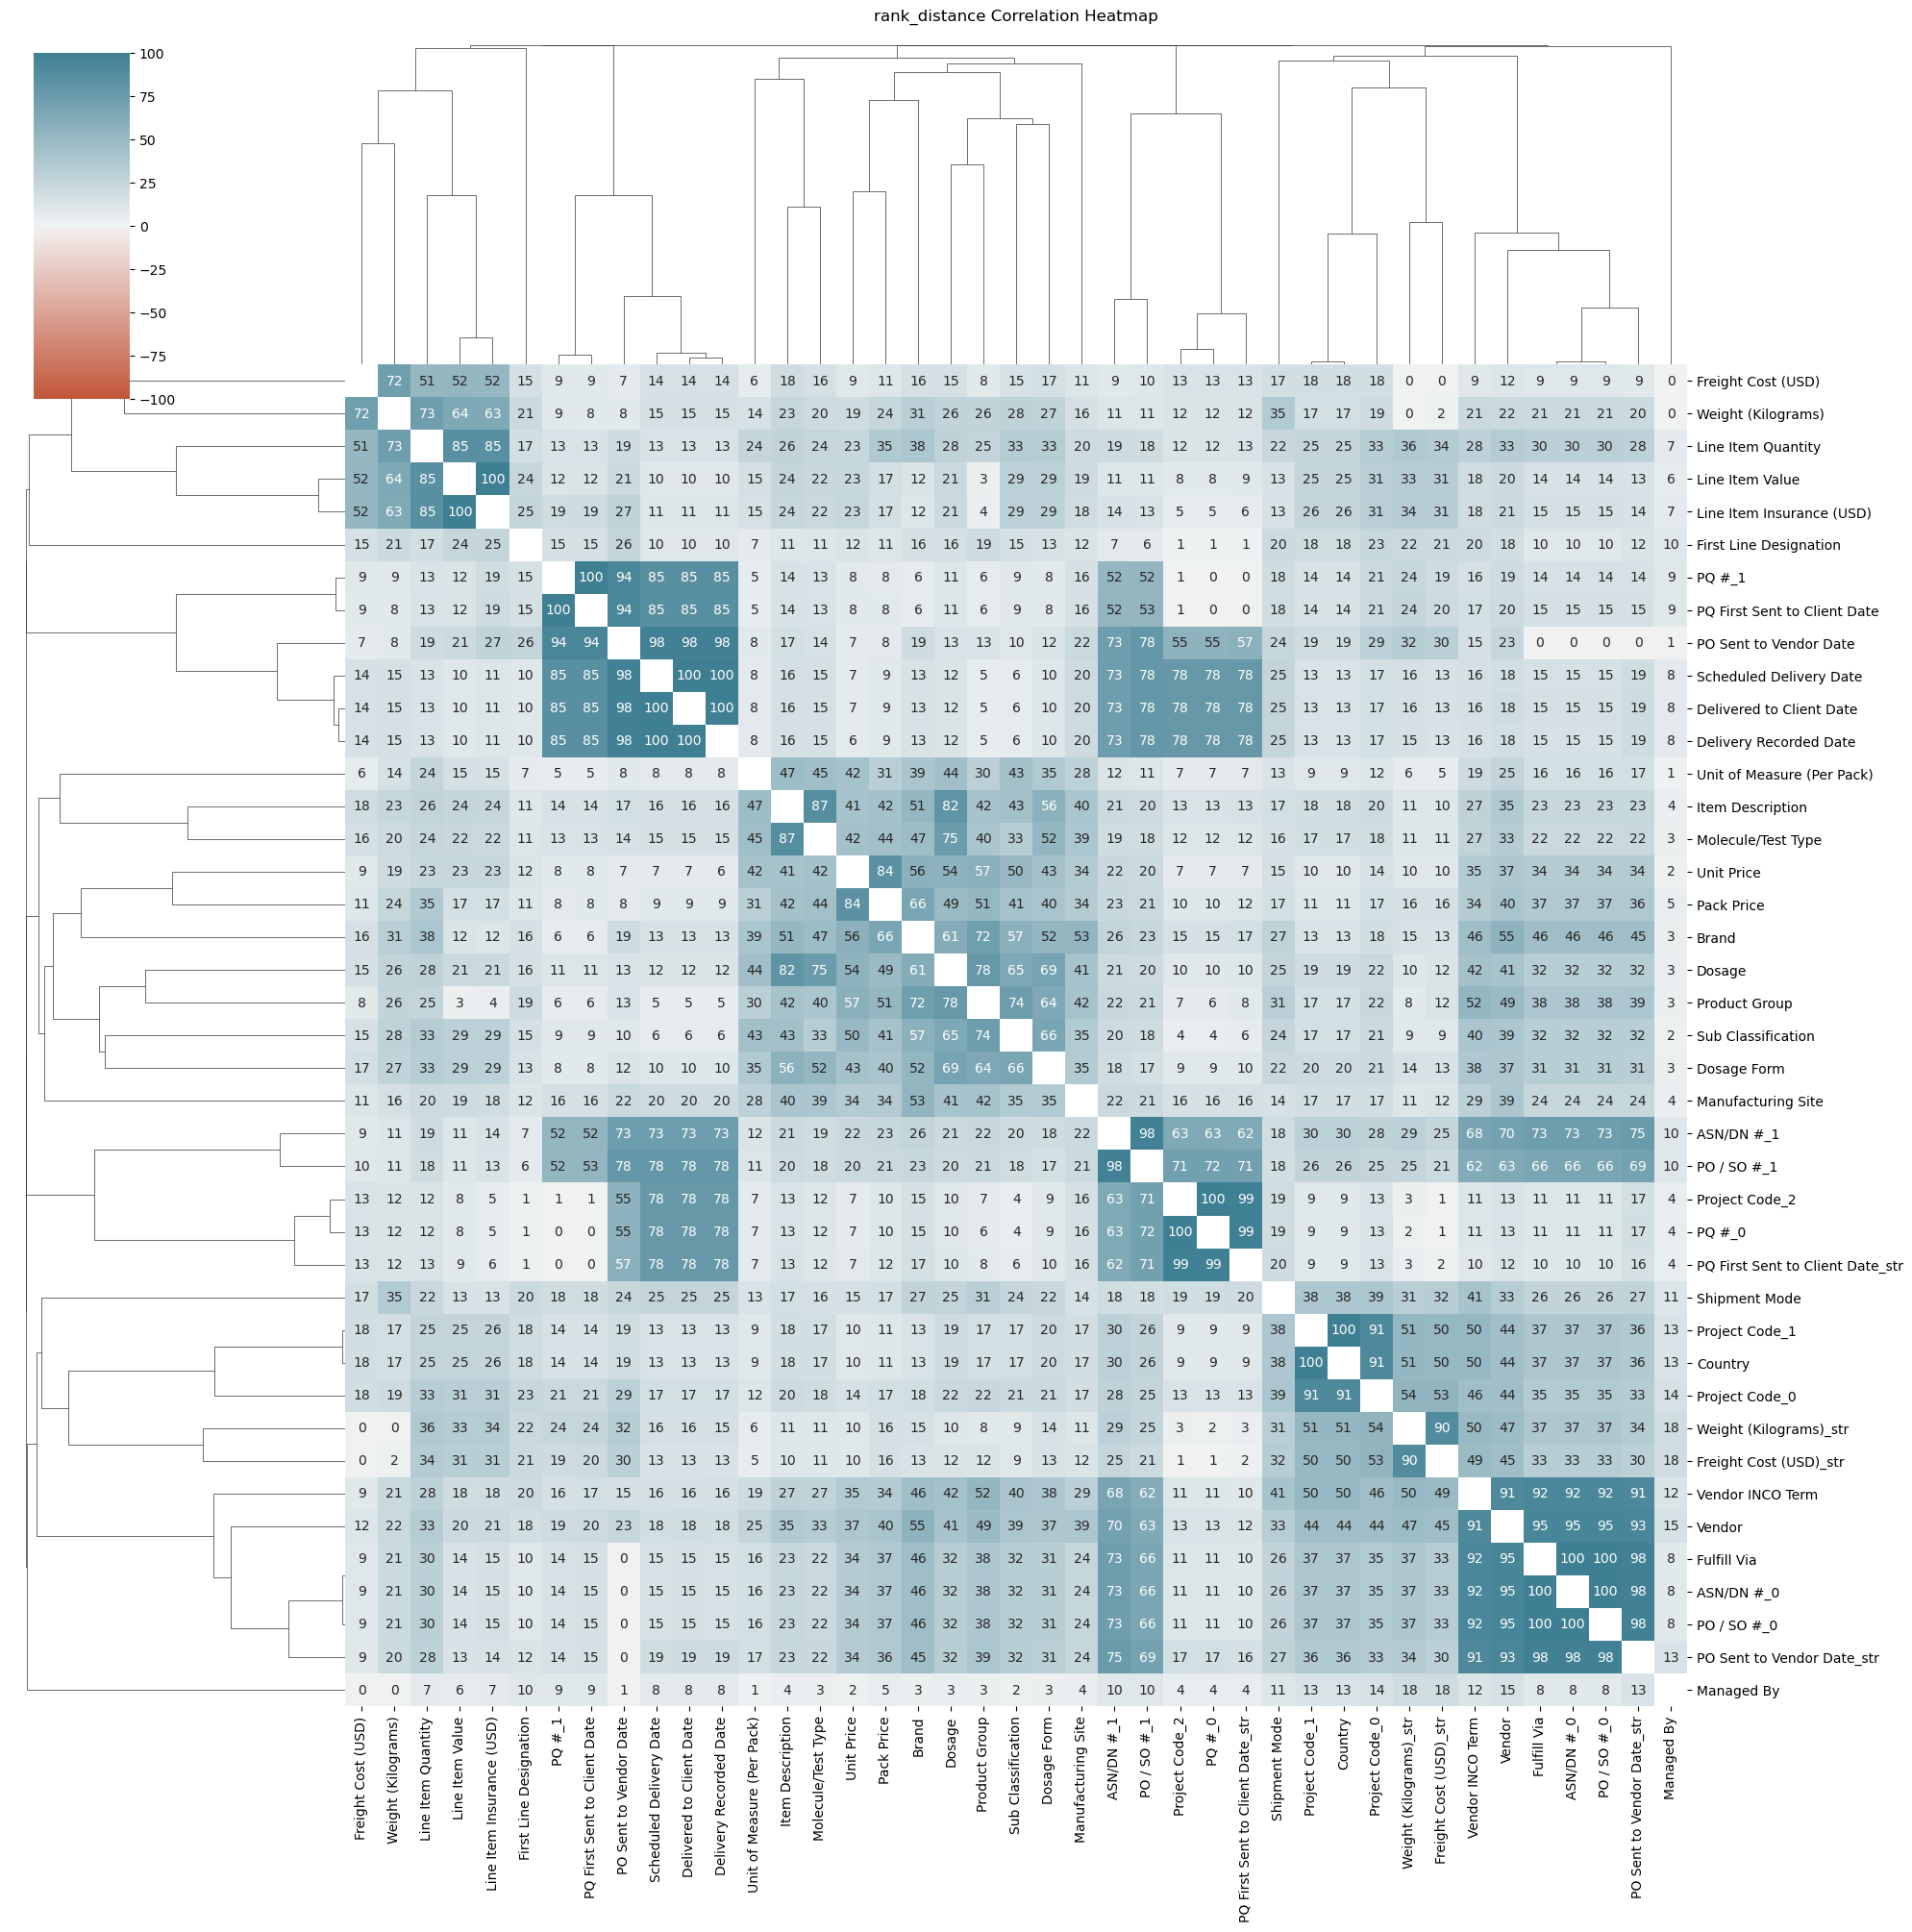

In [1399]:
g = dta.corr_heatmap(corr_method='rank_distance', figsize=(20, 20))

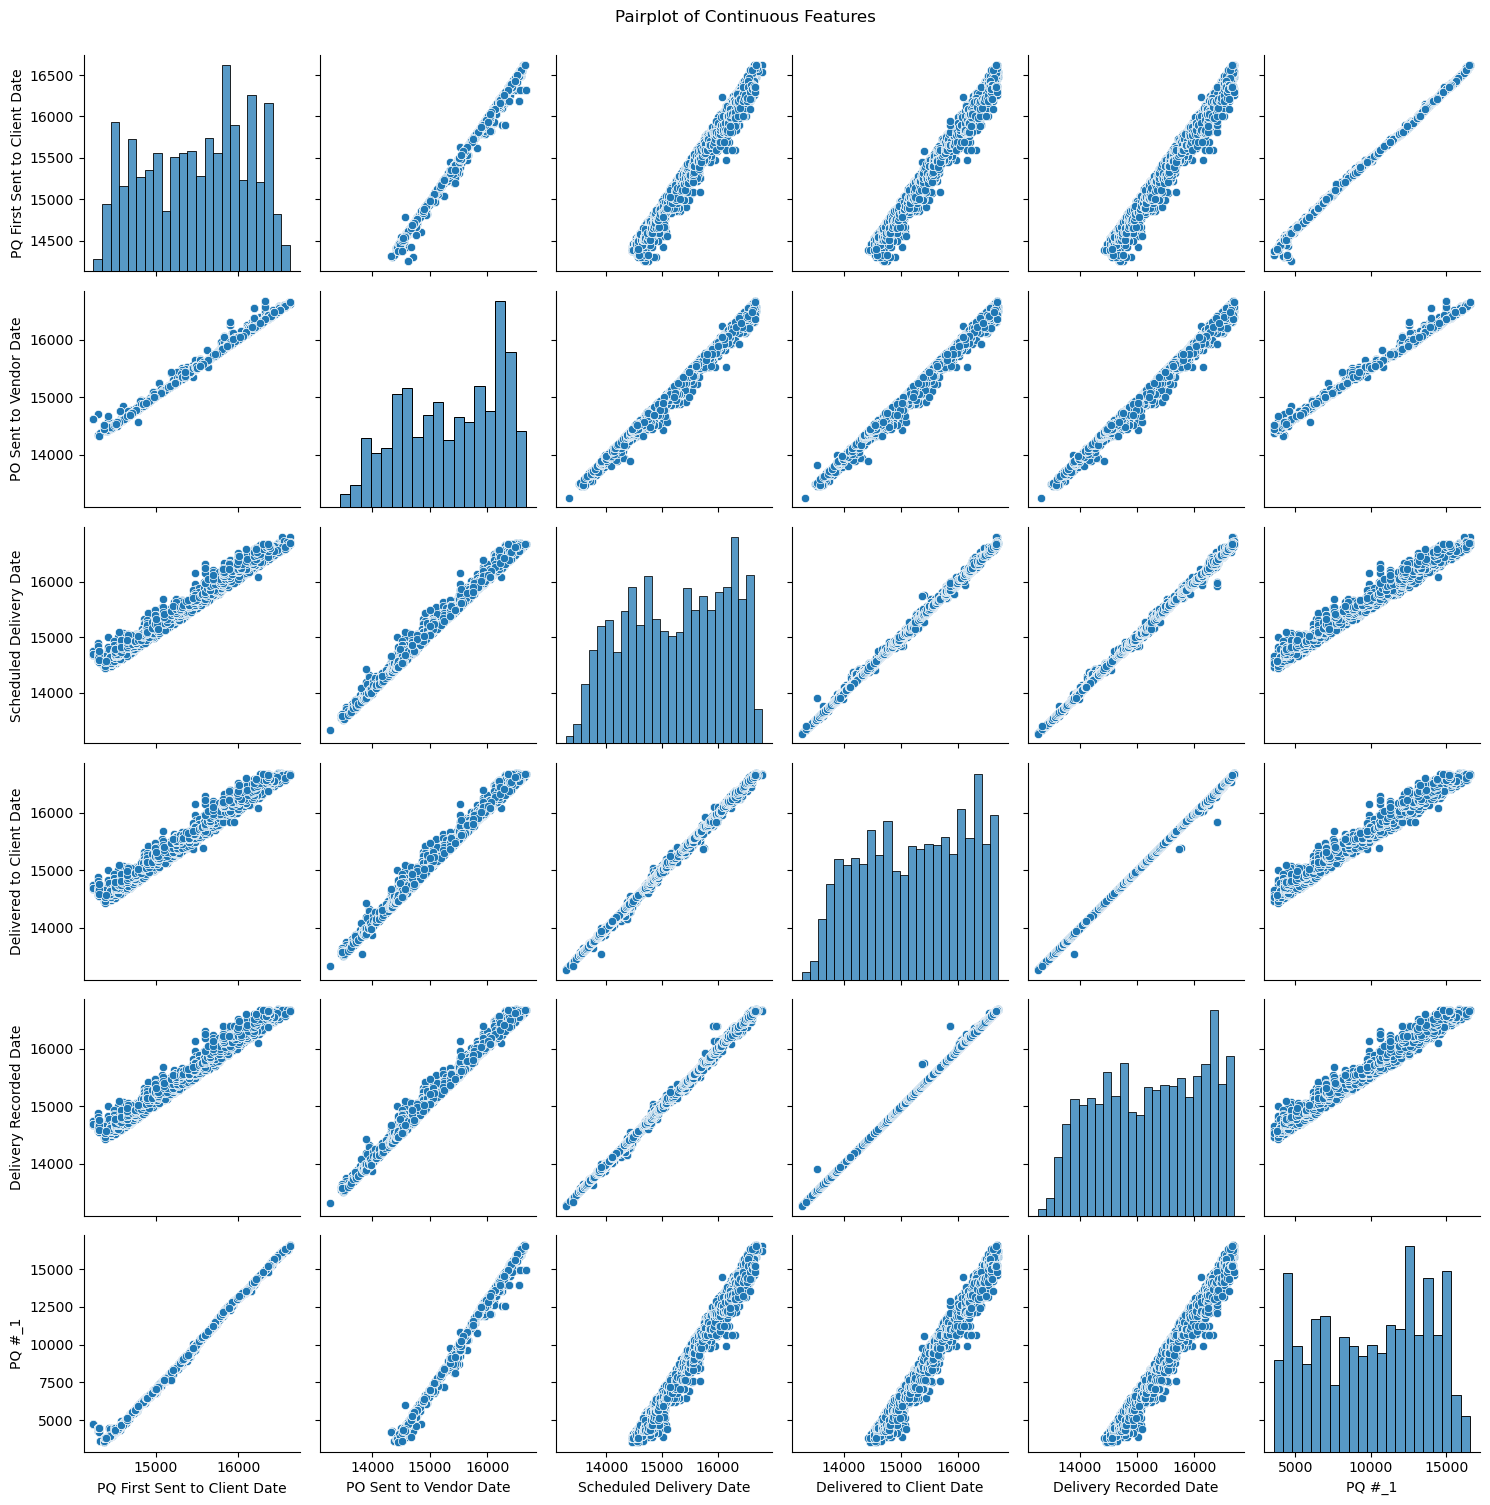

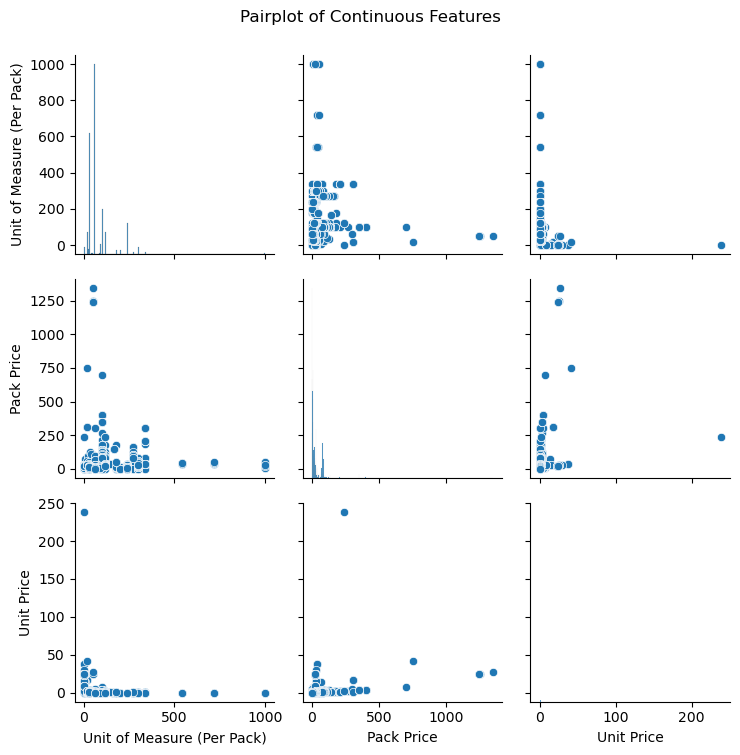

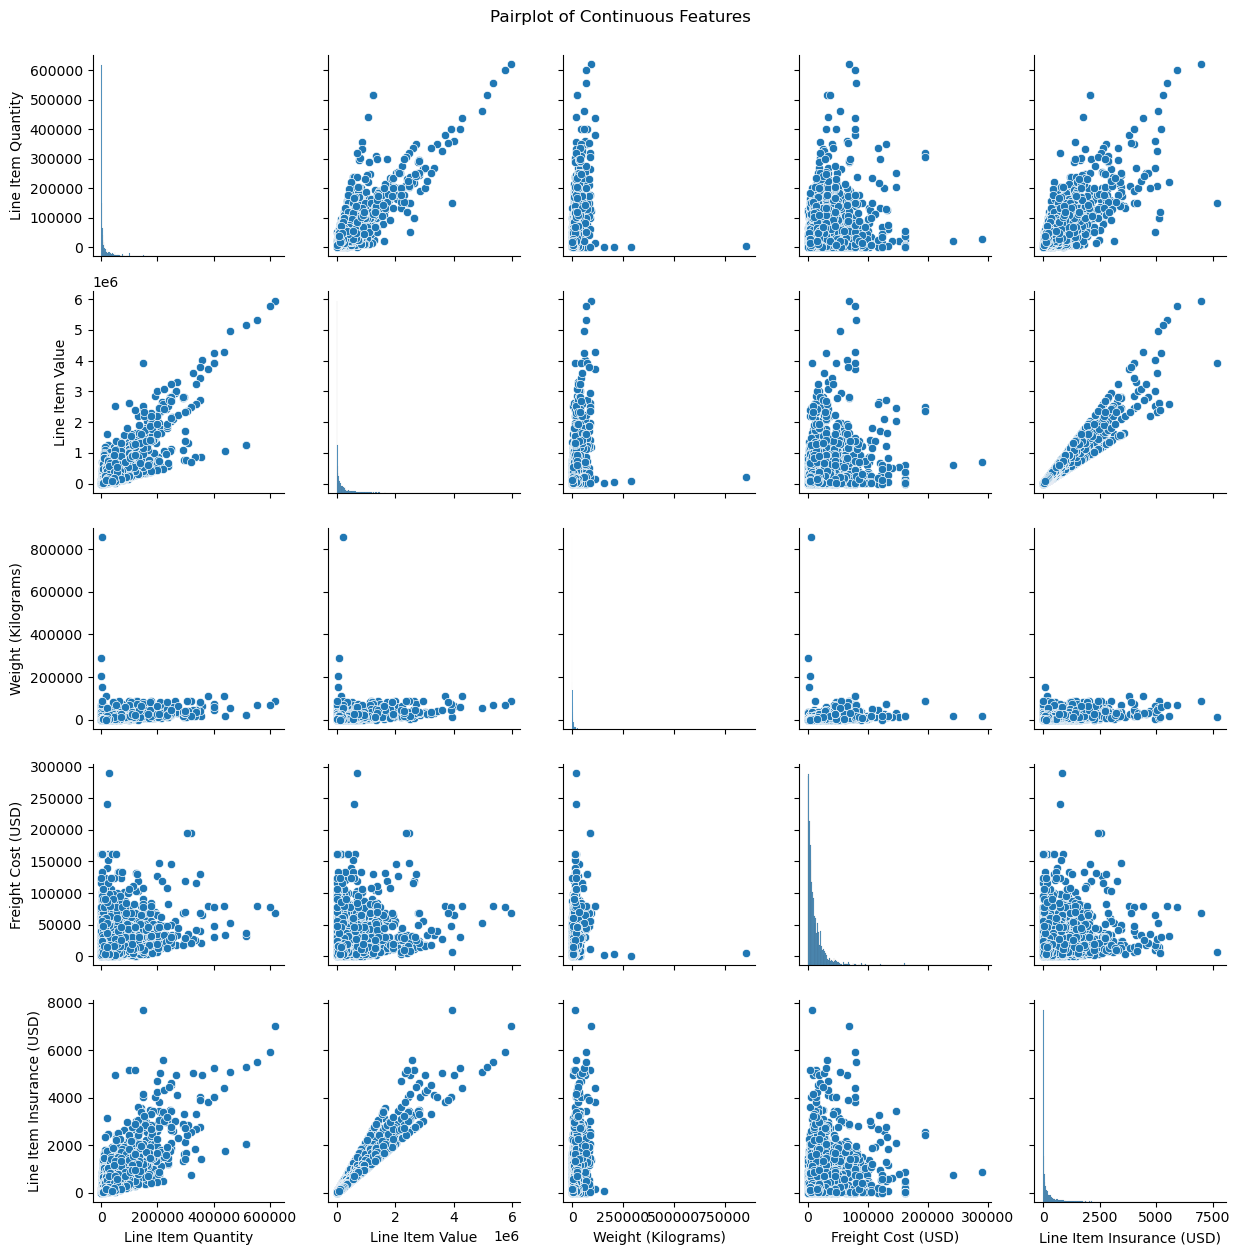

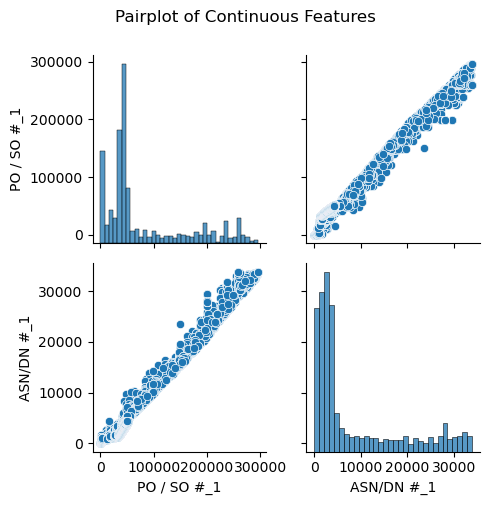

In [1409]:
cluster_book = dta.cluster_features(n_clusters=5)

for _, cols in cluster_book.items():
    if len([c for c in cols if c in dta.cont_cols]) <= 1:
        continue
    dta.pairplot(cols);

1. ```PQ #_1``` are just dates
2. ```Unit Price = Pack Price / Unit of Measure (Per Pack)```, but rounded to 2 d.p.
3.  ```Pack Price = Line Item Value / Line Item Quantity```
4.  We should normalize ```Line Item Insurance (USD)```  by ```Line Item Value```

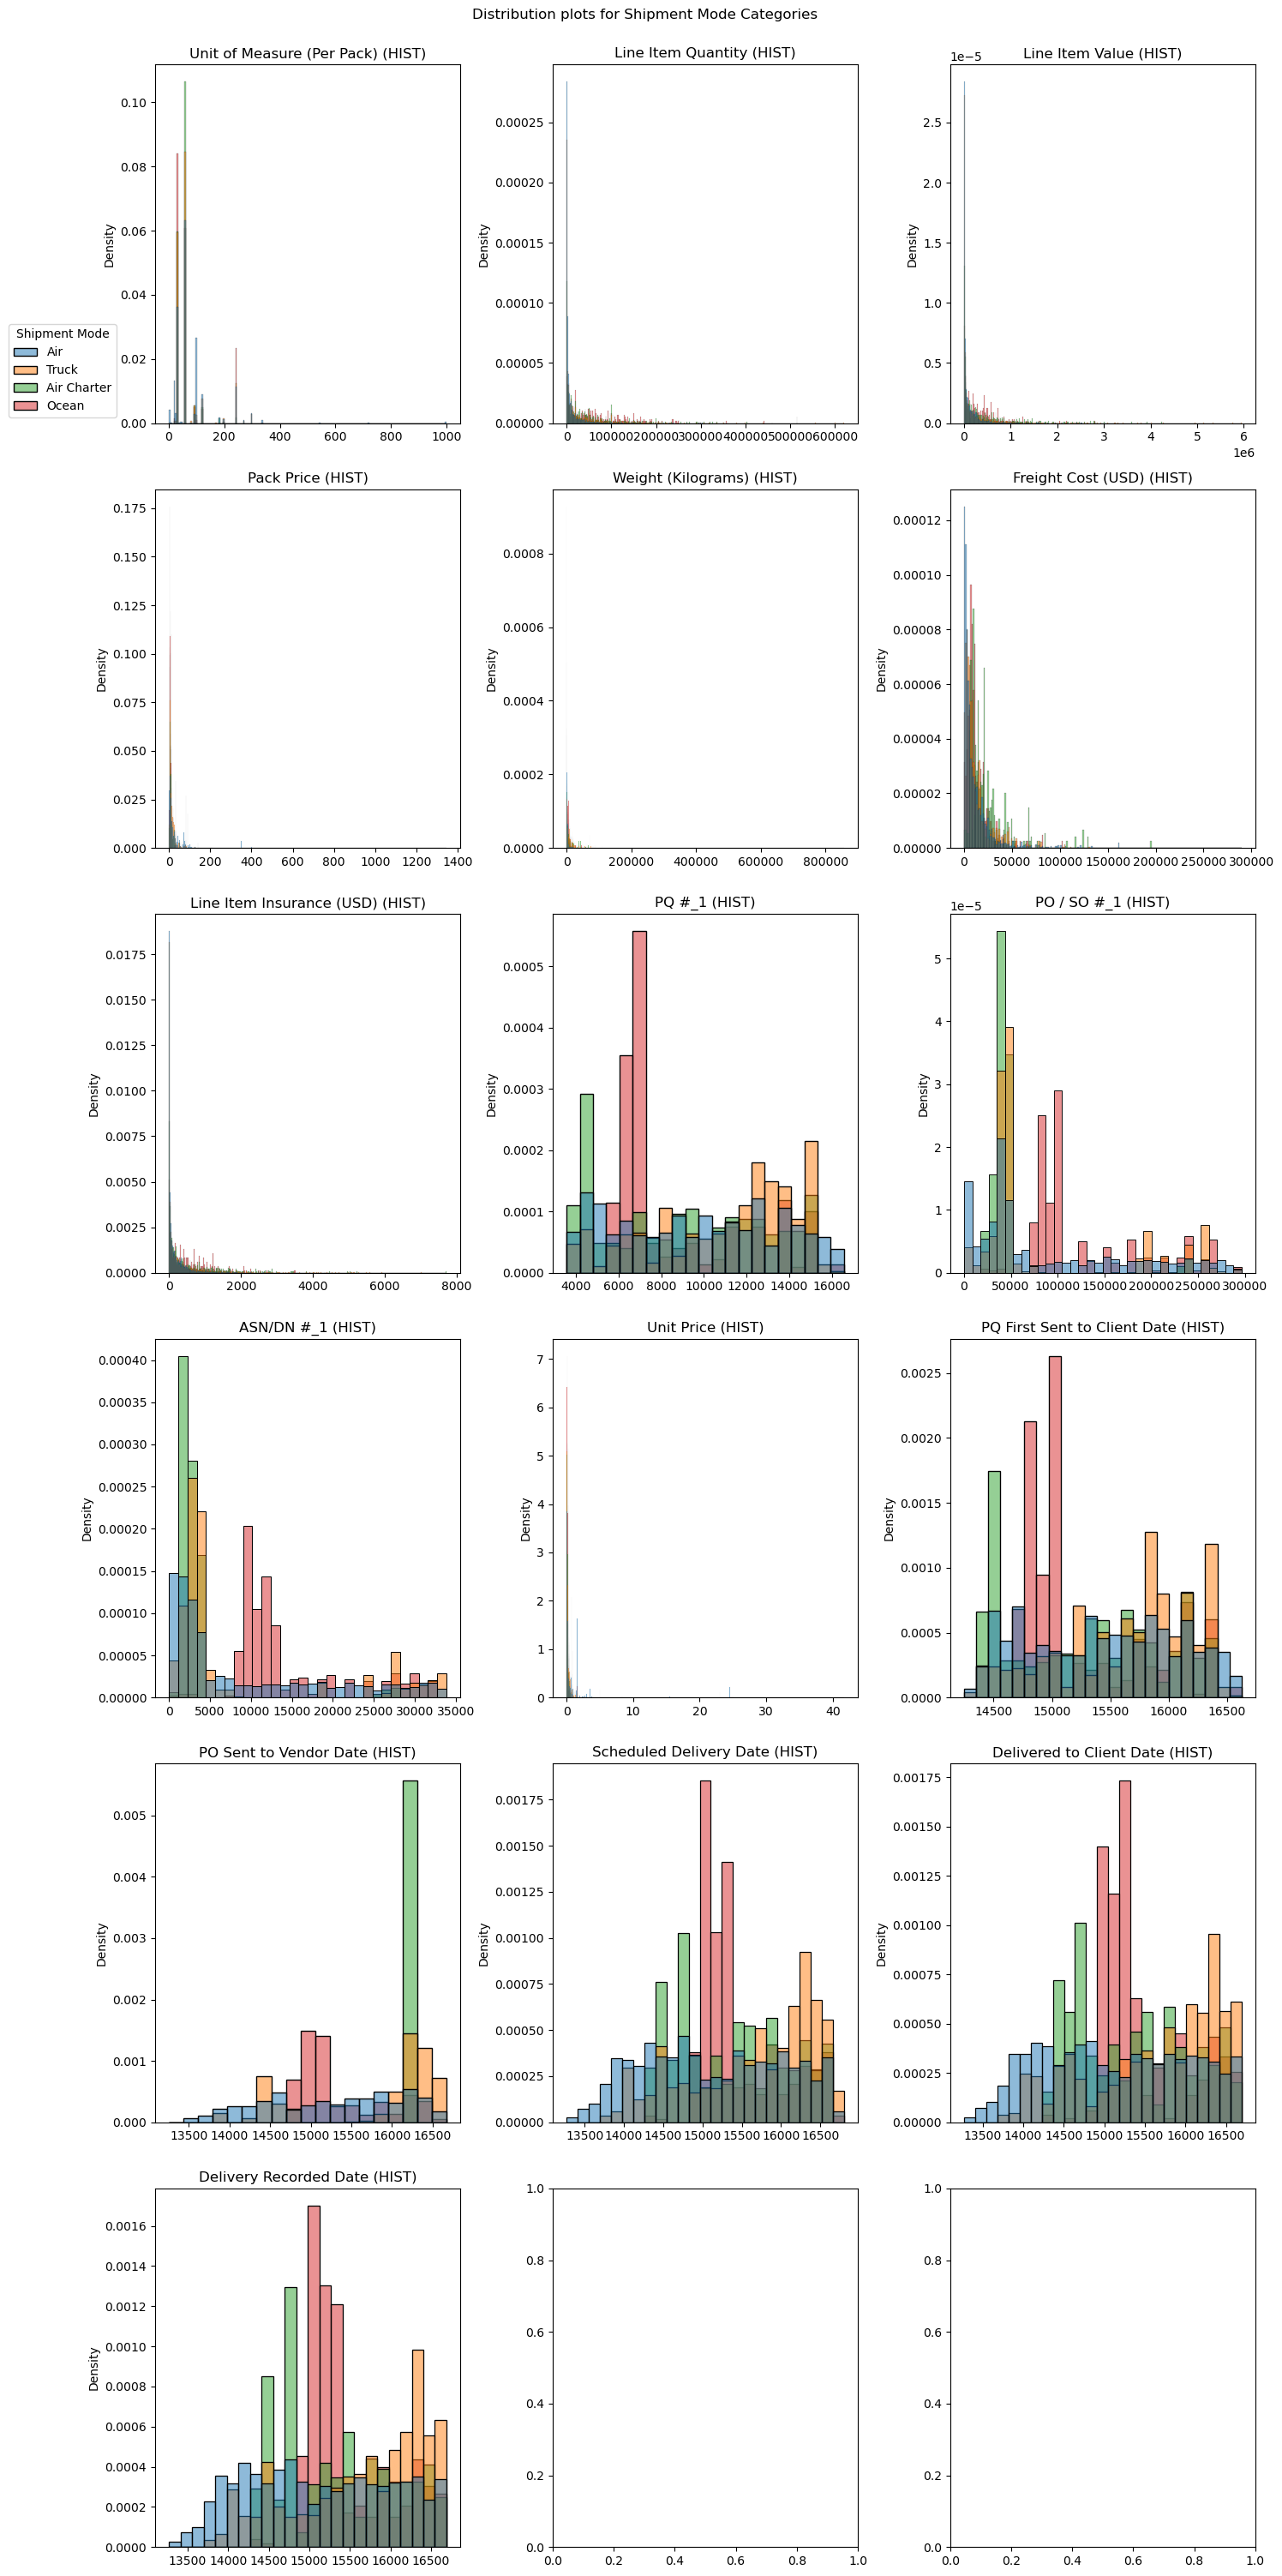

In [1411]:
dta.dist_plot_by_categ('Shipment Mode', kind='hist')

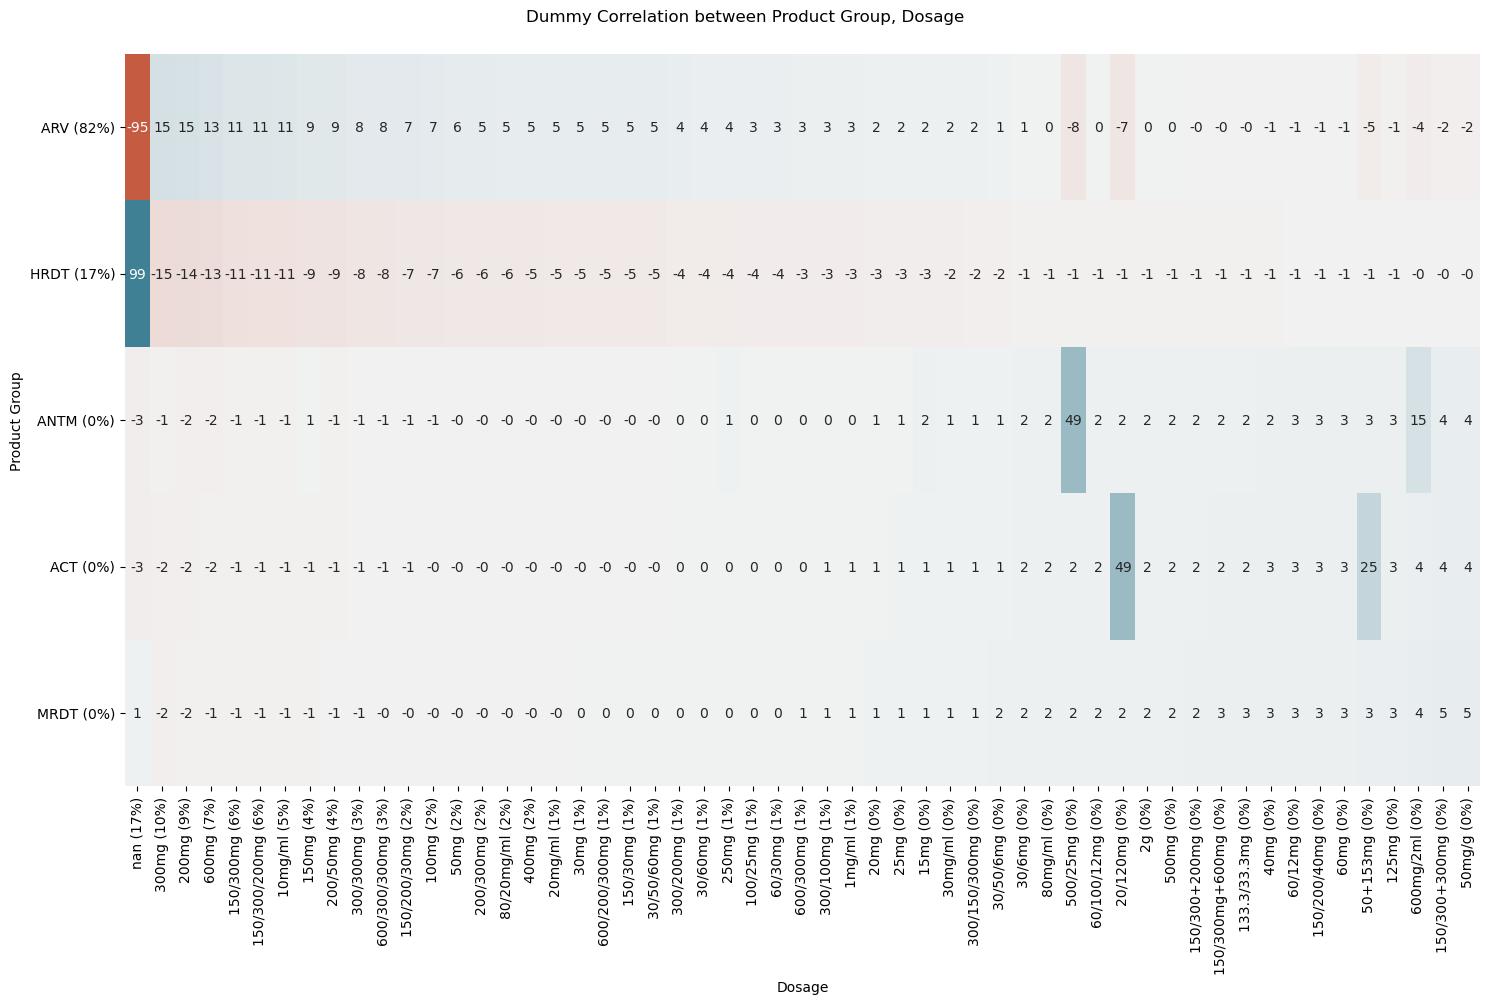

In [1425]:
dta.plot_contingency('Product Group', 'Dosage', corr=True, one_figsize=(15, 10));

### 2.1 Feature Engineering

In [1515]:
df2 = dta.df.copy()

df2['Insurance Ratio'] = df2['Line Item Insurance (USD)'] / df2['Line Item Value']
df2

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,...,PO / SO #_0,PO / SO #_1,ASN/DN #_0,ASN/DN #_1,PQ First Sent to Client Date_str,PO Sent to Vendor Date_str,Weight (Kilograms)_str,Freight Cost (USD)_str,Unit Price,Insurance Ratio
ID,,,,,,,,,,,,,,,,,,,,,
1,9,2,0,5,0,NaN,NaN,13301.0,13301.0,13301.0,...,1,4,0,8,1,0,1,2,0.97,NaN
3,40,2,0,5,0,NaN,NaN,13466.0,13466.0,13466.0,...,1,13,0,85,1,0,1,2,0.03,NaN
4,9,2,0,6,0,NaN,NaN,13387.0,13387.0,13387.0,...,1,20,0,14,1,0,1,2,0.80,NaN
15,40,2,0,5,0,NaN,NaN,13392.0,13392.0,13392.0,...,1,78,0,50,1,0,1,2,0.07,NaN
16,40,2,0,5,0,NaN,NaN,13371.0,13371.0,13371.0,...,1,81,0,55,1,0,1,2,0.05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86818,42,2,1,7,3,16359.0,NaN,16647.0,16631.0,16636.0,...,2,50020,1,4307,2,1,1,2,0.06,0.001177
86819,9,2,1,7,3,16367.0,NaN,16647.0,16653.0,16654.0,...,2,50102,1,4313,2,1,1,2,0.11,0.001177
86821,41,2,1,7,3,16294.0,NaN,16678.0,16672.0,16681.0,...,2,49600,1,4316,2,1,0,0,0.33,0.001028


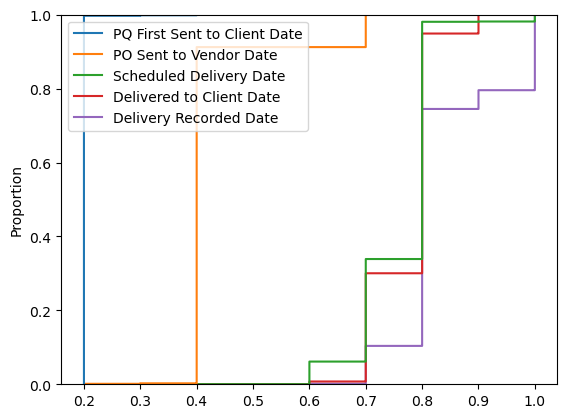

In [1541]:
sns.ecdfplot(dta.df[dta.date_cols].dropna().rank(axis=1, pct=True));

In [1521]:
df2['Vendor Minus Client Day'] = df2['PO Sent to Vendor Date'] - df2['PQ First Sent to Client Date']
df2['Delivered Minus Scheduled'] = df2['Delivered to Client Date'] - df2['Scheduled Delivery Date']
df2['Recorded Minus Scheduled'] = df2['Delivery Recorded Date'] - df2['Scheduled Delivery Date']
df2

,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,...,ASN/DN #_1,PQ First Sent to Client Date_str,PO Sent to Vendor Date_str,Weight (Kilograms)_str,Freight Cost (USD)_str,Unit Price,Insurance Ratio,Vendor Minus Client Day,Recorded Minus Scheduled,Delivered Minus Scheduled
ID,,,,,,,,,,,,,,,,,,,,,
1,9,2,0,5,0,NaN,NaN,13301.0,13301.0,13301.0,...,8,1,0,1,2,0.97,NaN,NaN,0.0,0.0
3,40,2,0,5,0,NaN,NaN,13466.0,13466.0,13466.0,...,85,1,0,1,2,0.03,NaN,NaN,0.0,0.0
4,9,2,0,6,0,NaN,NaN,13387.0,13387.0,13387.0,...,14,1,0,1,2,0.80,NaN,NaN,0.0,0.0
15,40,2,0,5,0,NaN,NaN,13392.0,13392.0,13392.0,...,50,1,0,1,2,0.07,NaN,NaN,0.0,0.0
16,40,2,0,5,0,NaN,NaN,13371.0,13371.0,13371.0,...,55,1,0,1,2,0.05,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86818,42,2,1,7,3,16359.0,NaN,16647.0,16631.0,16636.0,...,4307,2,1,1,2,0.06,0.001177,NaN,-11.0,-16.0
86819,9,2,1,7,3,16367.0,NaN,16647.0,16653.0,16654.0,...,4313,2,1,1,2,0.11,0.001177,NaN,7.0,6.0
86821,41,2,1,7,3,16294.0,NaN,16678.0,16672.0,16681.0,...,4316,2,1,0,0,0.33,0.001028,NaN,3.0,-6.0


## 3. Fit Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from CIBer import CIBer

cont_cols = dta.cont_cols
cont_cols_idx = list(dta.map2idx(cont_cols))

CIBer = CIBer(cont_col=cont_cols_idx, asso_method='modified', min_asso=0.95,
              disc_method='wpkid', n_iter=100, joint_encode=True)

baseline_models = {
    'CIBer': CIBer, 
    'Gaussian_NB': GaussianNB(),
    'Composite_NB': ut.CompositeNB(cont_cols=cont_cols_idx),
    'SVM': SVC(kernel='linear'), 
    'Logistic': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(),
    'LDA_PCA': Pipeline([
        ('pca', PCA(n_components=0.99)),
        ('lda', LinearDiscriminantAnalysis())]),
    'Decision_Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [15]:
n_iterations = 300
split_kws = {'max_batch_size': None,
             'test_size': 0.2, 
             'q_clip': 0.01, 
             'scaler': 'Standard', 
             'oversample': False}

class_reps = defaultdict(dict)

def _run_one(t):
    class_reps = {}
    X_train, X_test, y_train, y_test = dta.split_data(random_state=random_state + t, **split_kws)
        
    for name, model in baseline_models.items():
        model.fit(X_train.values, y_train.values)
        y_pred = model.predict(X_test.values)
        assert np.isfinite(y_pred).all()
        
        class_reps[name] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    class_reps = pd.concat(class_reps, axis=1, names=['model', 'stat'])
    return class_reps

res = ut.parallel(_run_one, range(n_iterations))
res = pd.concat(res, names=['iter', 'class'])

100%|█████████████████████████████████████████| 300/300 [00:21<00:00, 14.20it/s]


/var/folders/cm/9l2pfgfj3c7b3t18cyph49580000gn/T/ipykernel_87074/2440316972.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for stat, stat_table in stats.groupby('stat', axis=1, sort=False):


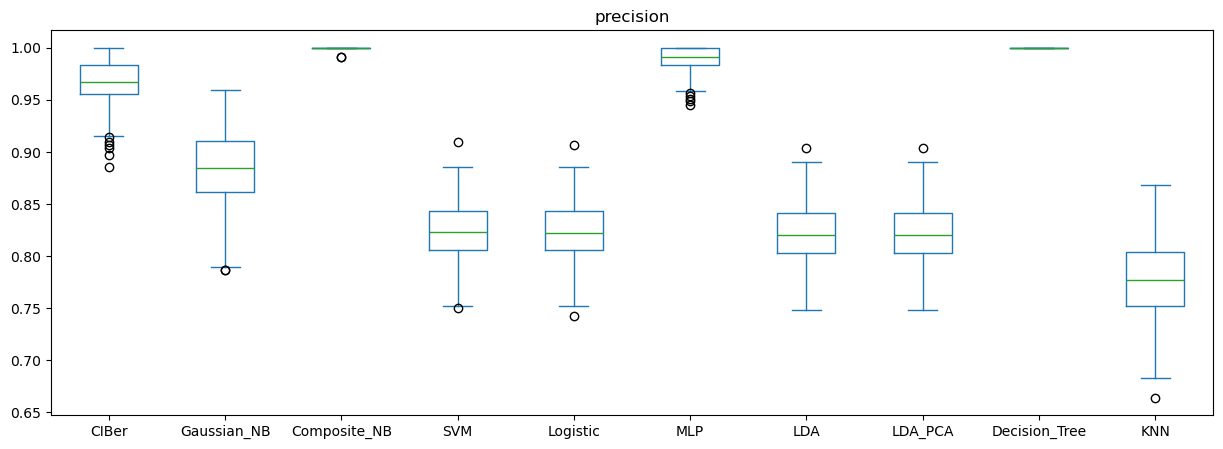

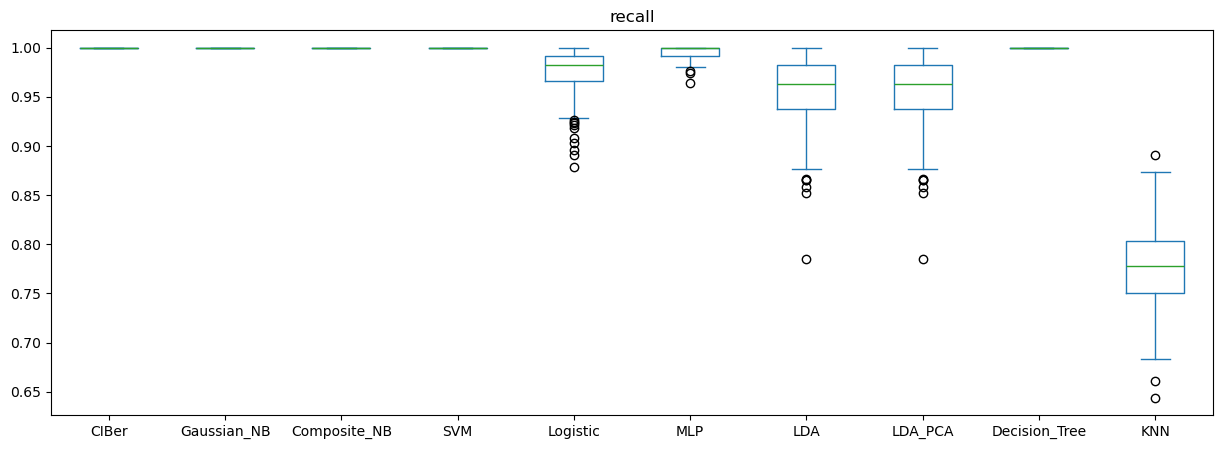

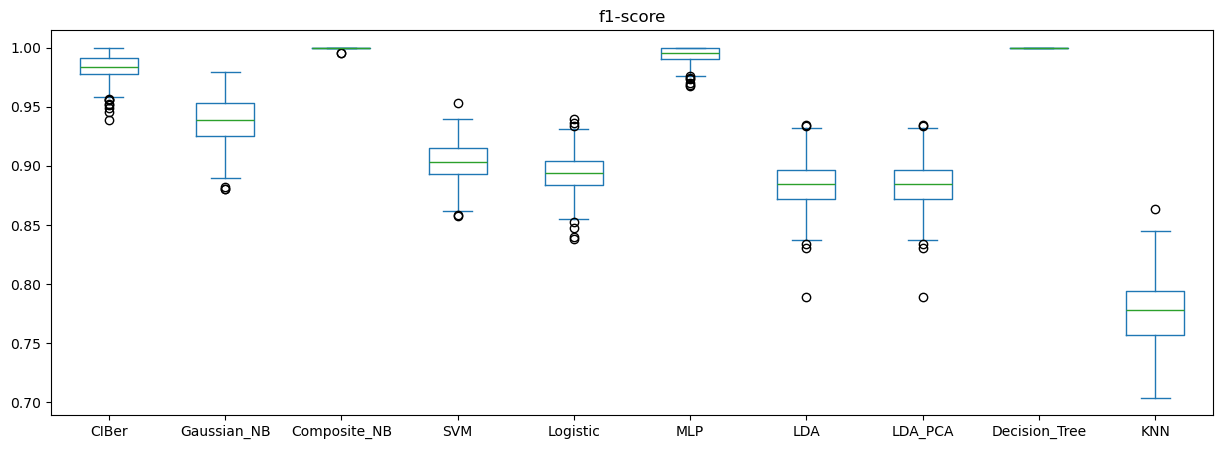

In [16]:
stats = res.drop(columns='support', level='stat', axis=1).xs("1", level='class')

for stat, stat_table in stats.groupby('stat', axis=1, sort=False):
    stat_table = stat_table.xs(stat, level='stat', axis=1)
    stat_table.plot(kind='box', title=stat, figsize=(15, 5))